# Exercise Performance and Calorie Expenditure Analysis

#### Fawzan Shaikh



### 1. Project Overview

Predicting caloric expenditure is often oversimplified into broad categories like "Cardio" vs. "Strength." This project moves beyond simple labels to investigate the actual physiological drivers of energy expenditure using Gym Members Exercise Dataset from Kaggle (973 samples).

#### __Quick Summary__:

__Objective:__ Identify the primary drivers of calorie expenditure during workout sessions.

__Methods:__ Data cleaning, Exploratory Data Analysis, One-Way ANOVA, and OLS Multiple Linear Regression

__Key Finding:__ Intensity metrics, specifically session length and frequency, have significantly higher predictive power than categorical labels like gender or workout type.

__Actionable Insight:__ To maximize efficiency, users should prioritize __session volume and consistency__ over specific "high-burn" workout labels, as these activity labels have shown only marginal statistical impact.

#### __Analytical Strategy__: 
To reach these conclusions, the analysis follows a three-stage technical roadmap:

__Exploratory Analysis:__ Conducted a comprehensive audit of all features to identify which variables showed the strongest initial correlation with total caloric expenditure.

__Statistical Inference: =__ Using ANOVA to test the validity of "Workout Type" as a meaningful predictor.

__Predictive Modeling:__ Implementing an OLS Regression model to quantify the "weight" of physiological variables (e.g., Heart Rate, Fat Percentage) against demographics

### 2. Data Preparation

#### 2.1 Data Importing

In [81]:
# Importing all necessary libraries

# Data analysis libraries
import pandas as pd

# Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothesis test library
from scipy.stats import f_oneway  # For performing one-way ANOVA tests

# Filter warnings to ensure a clean notebook
# Used to hide deprecation notices from libraries like Seaborn while maintaining code functionality.
import warnings
warnings.filterwarnings('ignore')   

Gym Members Exercise Dataset was downloaded from [kaggle](https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset) 

In [82]:
# loading the dataset
exercise_df = pd.read_csv("Data/gym_members_exercise_tracking.csv")

#### 2.2 Data Viewing

##### Dataset First View

In [83]:
# Display the first 10 rows
exercise_df.head(10)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
5,56,Female,58.0,1.68,168,156,74,1.59,1116.0,HIIT,15.5,2.7,5,3,20.55
6,36,Male,70.3,1.72,174,169,73,1.49,1385.0,Cardio,21.3,2.3,3,2,23.76
7,40,Female,69.7,1.51,189,141,64,1.27,895.0,Cardio,30.6,1.9,3,2,30.57
8,28,Male,121.7,1.94,185,127,52,1.03,719.0,Strength,28.9,2.6,4,2,32.34
9,28,Male,101.8,1.84,169,136,64,1.08,808.0,Cardio,29.7,2.7,3,1,30.07


##### DataSet Rows & Column Count

In [84]:
# Print the dimensions of the dataset to understand its size
print(f'Number of Rows is {exercise_df.shape[0]}')
print(f'Number of Columns is {exercise_df.shape[1]}')

Number of Rows is 973
Number of Columns is 15


##### Dataset Information

In [85]:
# Dataset information to verify data types and missing value counts
exercise_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

#### 2.3 Data Cleaning

The dataset required minimal cleaning. All columns were already correctly capitalized and had correct data types. There were no missing values in any column (df.isna().sum() = 0), so no removal of rows was necessary.   

Since the average BPM provides a more stable representation of intensity over the entire session, 'Max BPM' and 'Resting BPM' were removed.

##### Duplicate Values

In [86]:
# Dataset Duplicate Value Count
exercise_df.duplicated().sum()

0

##### Missing Values

In [87]:
# Count missing (NaN) values for each column to assess data quality
exercise_df.isna().sum()

Age                              0
Gender                           0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Workout_Type                     0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
dtype: int64

##### Changing Columns for better understandability

In [88]:
# Convert Gender and Workout_Type columns to category data type for better performance and memory efficiency
exercise_df["Gender"] = exercise_df["Gender"].astype("category")
exercise_df["Workout_Type"] = exercise_df["Workout_Type"].astype("category")

In [89]:
# Convert numeric Experience_Level values to descriptive strings for better interpretability
# Map: 1 = 'beginner', 2 = 'intermediate', 3 = 'advanced'
exercise_df['Experience_Level'] = exercise_df['Experience_Level'].replace({1: 'beginner', 2: 'intermediate', 3: 'advanced'}).astype(str)

# Verify that the conversion was applied correctly
exercise_df["Experience_Level"]

0          advanced
1      intermediate
2      intermediate
3          beginner
4          beginner
           ...     
968        advanced
969        beginner
970        advanced
971    intermediate
972        beginner
Name: Experience_Level, Length: 973, dtype: object

##### Dropping columns not used in Analysis

In [90]:
# Remove Resting_BPM and Max_BPM columns as they are not needed for the analysis
# These are replaced by Average BPM which provides a more stable intensity measure
exercise_df = exercise_df.drop(columns=['Resting_BPM','Max_BPM'])

# Display the first few rows to verify that columns were successfully dropped
exercise_df.head()

,Age,Gender,Weight (kg),Height (m),Avg_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,157,1.69,1313.0,Yoga,12.6,3.5,4,advanced,30.20
1,46,Female,74.9,1.53,151,1.30,883.0,HIIT,33.9,2.1,4,intermediate,32.00
2,32,Female,68.1,1.66,122,1.11,677.0,Cardio,33.4,2.3,4,intermediate,24.71
3,25,Male,53.2,1.70,164,0.59,532.0,Strength,28.8,2.1,3,beginner,18.41
4,38,Male,46.1,1.79,158,0.64,556.0,Strength,29.2,2.8,3,beginner,14.39


I created a new derived column, calories per minute (cal_per_min), to help compare workout intensity across different activity types. 

In [91]:
# Convert session duration from hours to minutes for per-minute calculations
num_mins = exercise_df["Session_Duration (hours)"] * 60

# Calculate calories burned per minute to normalize for different workout durations
exercise_df["Cal_Burned_Per_Min"] = (exercise_df["Calories_Burned"] / num_mins).round(2)

# Display the updated dataframe to verify the new column was added correctly
exercise_df.head()

,Age,Gender,Weight (kg),Height (m),Avg_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Cal_Burned_Per_Min
0,56,Male,88.3,1.71,157,1.69,1313.0,Yoga,12.6,3.5,4,advanced,30.20,12.95
1,46,Female,74.9,1.53,151,1.30,883.0,HIIT,33.9,2.1,4,intermediate,32.00,11.32
2,32,Female,68.1,1.66,122,1.11,677.0,Cardio,33.4,2.3,4,intermediate,24.71,10.17
3,25,Male,53.2,1.70,164,0.59,532.0,Strength,28.8,2.1,3,beginner,18.41,15.03
4,38,Male,46.1,1.79,158,0.64,556.0,Strength,29.2,2.8,3,beginner,14.39,14.48


To improve the readability of the data, I relocated `calories_per_min` beside `total_calories_burned` for easier viewing and analysis. 

In [92]:
# Define the target column
target_col = 'Cal_Burned_Per_Min'

# Create a list of all other columns
cols = [c for c in exercise_df.columns if c != target_col]

# Insert target column at the desired index (e.g., index 7)
cols.insert(7, target_col)

# Reassign
exercise_df = exercise_df[cols]

# Output DF to verify succesful column change 
exercise_df.head()

,Age,Gender,Weight (kg),Height (m),Avg_BPM,Session_Duration (hours),Calories_Burned,Cal_Burned_Per_Min,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,157,1.69,1313.0,12.95,Yoga,12.6,3.5,4,advanced,30.20
1,46,Female,74.9,1.53,151,1.30,883.0,11.32,HIIT,33.9,2.1,4,intermediate,32.00
2,32,Female,68.1,1.66,122,1.11,677.0,10.17,Cardio,33.4,2.3,4,intermediate,24.71
3,25,Male,53.2,1.70,164,0.59,532.0,15.03,Strength,28.8,2.1,3,beginner,18.41
4,38,Male,46.1,1.79,158,0.64,556.0,14.48,Strength,29.2,2.8,3,beginner,14.39


No significant data quality issues were found, and the dataset was deemed suitable for exploratory analysis.

### 3. Exploratory Data Analysis (EDA)

Analyzed the relationships between workout characteristics and energy expenditure to identify the primary drivers of caloric burn.

* **Multivariate Analysis:** Key variables such as session duration, heart rate (BPM), and workout type were analyzed using a combination of summary statistics and targeted visualizations. 
* **Insight Generation:** This approach (tabular and visual) helped validate data distributions and reveal patterns that would inform the feature engineering phase.

In [93]:
# Exploring averages
exercise_df.mean(numeric_only=True).round(2)

Age                               38.68
Weight (kg)                       73.85
Height (m)                         1.72
Avg_BPM                          143.77
Session_Duration (hours)           1.26
Calories_Burned                  905.42
Cal_Burned_Per_Min                12.01
Fat_Percentage                    24.98
Water_Intake (liters)              2.63
Workout_Frequency (days/week)      3.32
BMI                               24.91
dtype: float64

Analyzing the data tells us about what sort of workout the people were doing. Data seems to be taken from a middle aged, average fitness level group, with a moderate level of workout frequency. 

In [94]:
# Descriptive statistics for the Calories_Burned column
ds = exercise_df.Calories_Burned.describe()

# Print key statistics: mean, max, and min values
print(f"Mean Calories Burned: {round(ds['mean'],2)}")
print(f"Max Calories Burned: {round(ds['max'],2)}")
print(f"Min Calories Burned: {round(ds['min'],2)}")

Mean Calories Burned: 905.42
Max Calories Burned: 1783.0
Min Calories Burned: 303.0


Upon further analyzing the calories, there is quite a bit of spread, suggesting that certain workout factors can greatly impact calories burned. The next section will examine this in greater detail. 

#### 3.1 Overall Distribution of Calories Burned: 

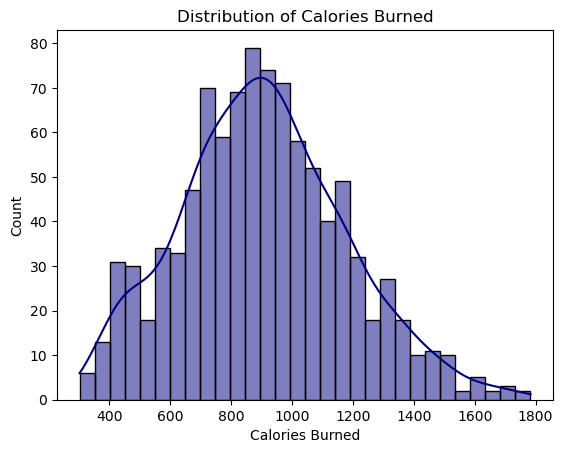

In [95]:
# Create a histogram to visualize the distribution of calories burned
sns.histplot(exercise_df['Calories_Burned'], bins=30, kde=True, color='navy')
plt.xlabel("Calories Burned")
plt.ylabel("Count")
plt.title("Distribution of Calories Burned")
plt.show()


Distriubtion follows a relatively normal curve, there are quite a few extremes. most of the exercises seem to burn around 700 to 1050 calories. 

now that we know what the data looks like, we can test an important question: 

#### 3.2 Does Workout Duration have an impact on calories burned?

Workout duration is expected to have a direct relationship with calorie expenditure. This relationship is explored using a scatter plot.


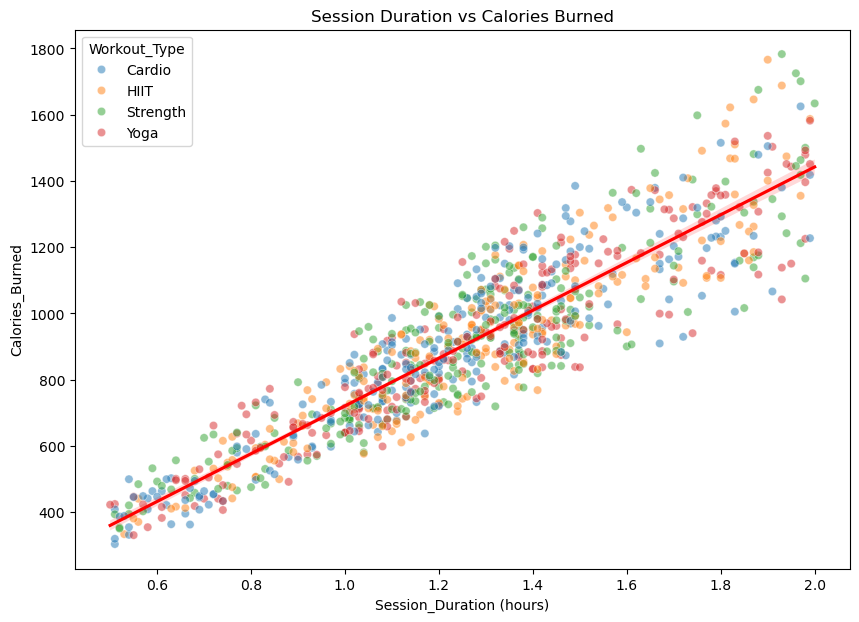

In [96]:
# Create a scatter plot to analyze the relationship between session duration and calories burned
plt.figure(figsize=(10,7))

sns.scatterplot(
    data=exercise_df, 
    x='Session_Duration (hours)', 
    y='Calories_Burned', 
    hue='Workout_Type',  
    alpha=0.5  
)

# Overlay a regression line to show the overall trend
sns.regplot(data=exercise_df, x='Session_Duration (hours)', y='Calories_Burned', scatter=False, color='red')

plt.title("Session Duration vs Calories Burned")
plt.show()

Longer workout sessions are generally associated with higher calorie expenditure, indicating a positive relationship between duration and calories burned.

#### 3.3 Heart Rate vs Calories Burned

Heart rate serves as a proxy for workout intensity. Higher average heart rates are expected to correspond to increased calorie burn.


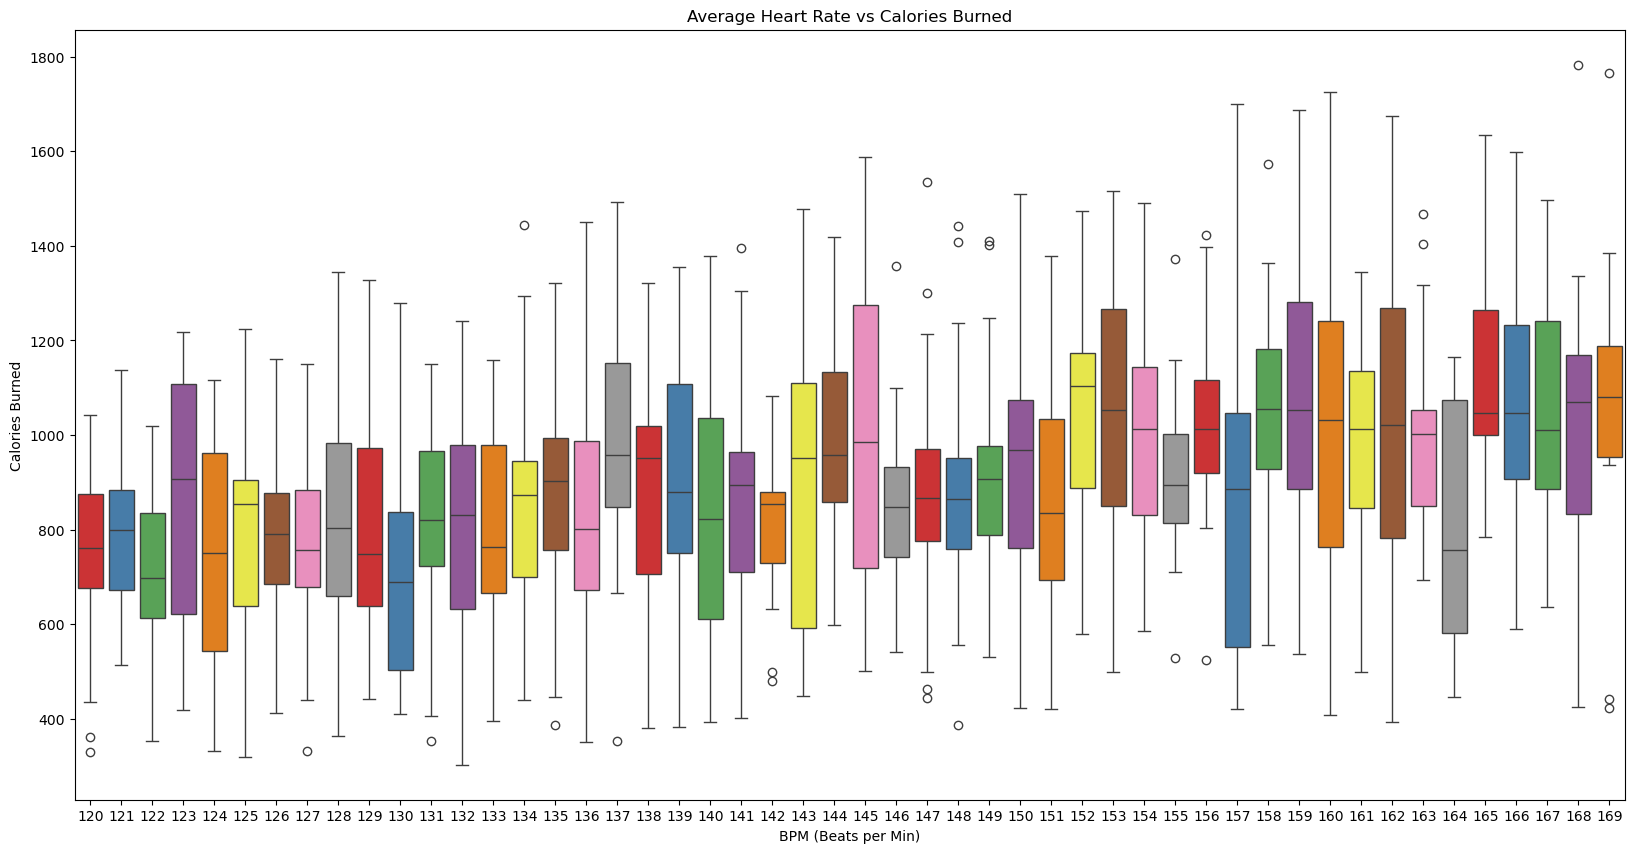

In [97]:
# Create a box plot to compare calories burned across different average BPM ranges
plt.figure(figsize=(20,10))
sns.boxplot(data=exercise_df, x='Avg_BPM', y='Calories_Burned', palette='Set1')
plt.xlabel("BPM (Beats per Min)")
plt.ylabel("Calories Burned")
plt.title("Average Heart Rate vs Calories Burned")
plt.show()


This comparison shows the typical calorie burn based on the average BPM. The boxplot shows that individuals with higher average heart rates tend to burn more calories, suggesting that workout intensity plays a significant role in calorie expenditure. A boxplot was chosen to show outliers, the plot reveals a high variance within intensity categories, with significant outliers across the board. 

These extremes suggest that factors beyond heart rate, such as gender or workout type, may be influencing expenditure in specific cases.

#### 3.4 Calories Burned by Workout Type

Different workout types vary in intensity and structure. Average calories burned were compared across workout categories.


In [98]:
# Group by workout type and calculate mean calories burned for each type
round(exercise_df.groupby("Workout_Type")["Calories_Burned"].mean().sort_values(ascending=False), 2)

Workout_Type
HIIT        925.81
Strength    910.70
Yoga        903.19
Cardio      884.51
Name: Calories_Burned, dtype: float64

HIIT and Strength training workouts show higher average calorie expenditure compared to Yoga and Cardio, consistent with their higher intensity levels.


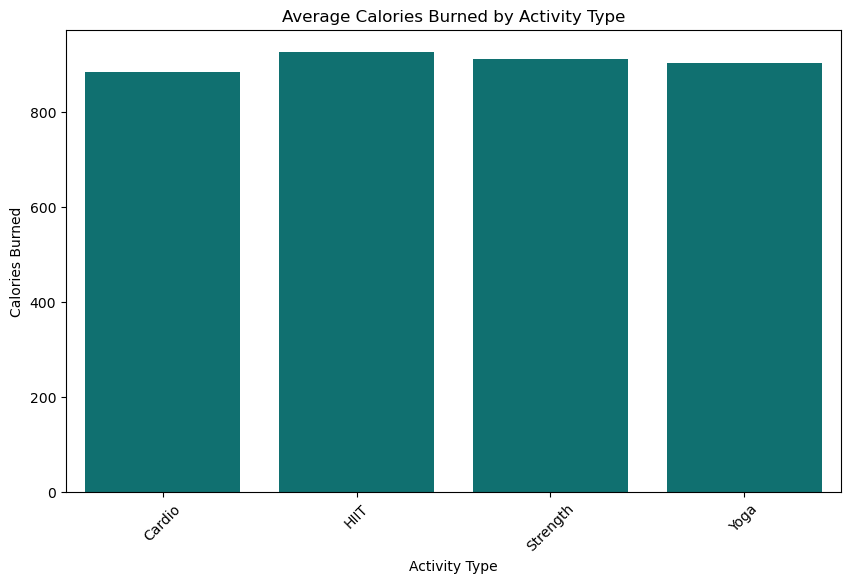

In [99]:
# Create a bar plot showing average calories burned for each workout type
plt.figure(figsize=(10,6))
sns.barplot(data=exercise_df, x='Workout_Type', y='Calories_Burned', ci=None, color='teal')
plt.xticks(rotation=45)
plt.title('Average Calories Burned by Activity Type')
plt.ylabel('Calories Burned')
plt.xlabel('Activity Type')
plt.show()

This comparison shows the typical calorie burn for each workout activity. The groupby statistics and barplot show that there isnt much of a difference between calories burned for each acitivty type.

 However, it is important to note that this shows the overall calorie burn. It does not take into account the duration, or other factors which may effect calories burned. 

In [100]:
# Group by workout type and calculate mean session duration for each type
round(exercise_df.groupby("Workout_Type")["Session_Duration (hours)"].mean().sort_values(ascending=False), 2)

Workout_Type
HIIT        1.29
Yoga        1.26
Strength    1.26
Cardio      1.22
Name: Session_Duration (hours), dtype: float64

From the statistic above, HIIT sessions tend to last for longer, which contributes to them burning the most calories. Conversely, cardio lessions are the shortest, which can help to explain why they burn the last amount of calories on average. 

From the earlier statistic (cell 44) that compared calorie burn to workout duration, it is clear that session duration has a positive correlation with total calorie expenditure. To normalize the data for a more accurate comparison, the following figure (barplot) will analyze **calories burned per minute** to evaluate activity effiency regardless of workout length

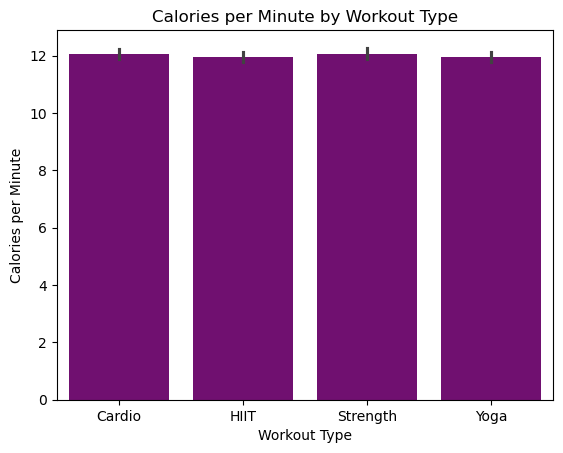

In [101]:
# Create a bar plot showing calories burned per minute for each workout type
sns.barplot(data=exercise_df, x='Workout_Type', y='Cal_Burned_Per_Min', color='purple')
plt.xlabel("Workout Type")
plt.ylabel("Calories per Minute")
plt.title("Calories per Minute by Workout Type")
plt.show()

The bar plot above shows that each of the four workout types burn roughly the same amount of calories per min. 

From the data above, we can not conclude that any certain workout activity burns more calories compared to the others. But, this could be because of additional factors such as gender. To test this new hypothesis the following plots and data will examine the effect of gender on calories in several ways. 

#### 3.5 Does gender effect calories burned:

In [102]:
# Group by gender and calculate mean calories burned for each gender
exercise_df.groupby('Gender')['Calories_Burned'].mean()

Gender
Female    862.248918
Male      944.455969
Name: Calories_Burned, dtype: float64

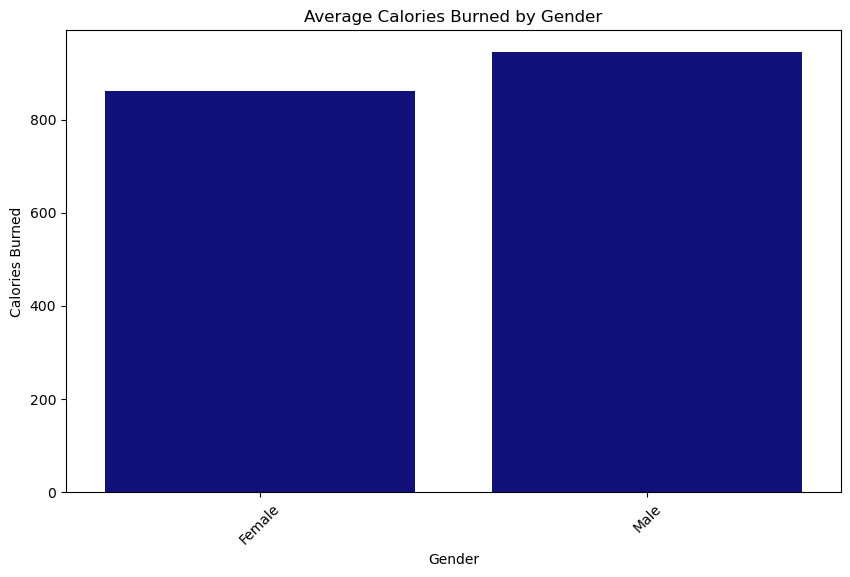

In [103]:
# Create a bar plot comparing average calories burned between genders
plt.figure(figsize=(10,6))
sns.barplot(data=exercise_df, x='Gender', y='Calories_Burned', ci=None, color='darkblue')
plt.xticks(rotation=45)
plt.title('Average Calories Burned by Gender')
plt.ylabel('Calories Burned')
plt.xlabel('Gender')
plt.show()

after examing the barplot and the groupby stats above, gender seems to have a small, but noticeable difference in calories burned, with men bruning around 82 calories than women on average. 

Gender alone does not seem to have a huge difference on calorie burn. The next analysis will examine if activity type effects calorie burn differently for each gender. 

#### 3.6 Does Workout Type make a difference on calories burned for each gender?:

In [104]:
# Group by both gender and workout type to see mean calories burned for each combination
exercise_df.groupby(['Gender', 'Workout_Type'])['Calories_Burned'].mean()

Gender  Workout_Type
Female  Cardio          834.793651
        HIIT            869.953271
        Strength        863.097561
        Yoga            886.122642
Male    Cardio          933.077519
        HIIT            978.228070
        Strength        954.066667
        Yoga            916.789474
Name: Calories_Burned, dtype: float64

The initial analysis measured total caloric expenditure across activities. However, from earlier analysis, it is evident that duration can effect the amount of calories burned. To isolate the impact of the activity and gender, the following analysis will use calories burned per minute to account for the differences in duration. 

barplot shows which activities burn the most calories on average per minute for each gender.

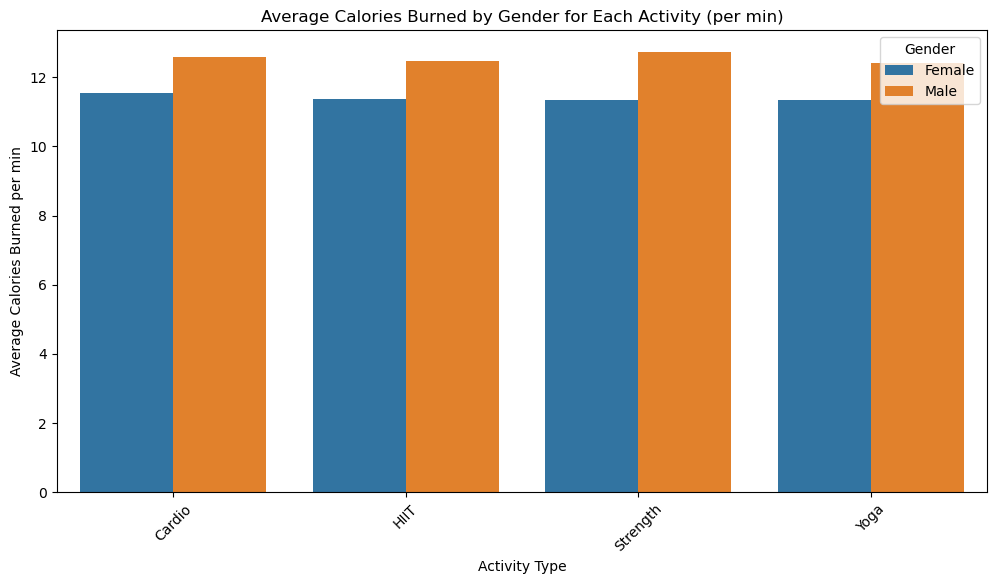

In [105]:
# Create a barplot comparing calories burned per minute by each gender and workout type combination
plt.figure(figsize=(12,6))
sns.barplot(data=exercise_df, x='Workout_Type', y='Cal_Burned_Per_Min', hue='Gender', ci=None)
plt.xticks(rotation=45)
plt.title('Average Calories Burned by Gender for Each Activity (per min)')
plt.ylabel('Average Calories Burned per min')
plt.xlabel('Activity Type')
plt.show()

Workout duration can affect calories burned. Calories per minute adjusts for this and provides a more fairer comparison. This figure shows that men burn calories at a faster rate independent of workout length and even in the same activities. 

## 4.0 Correlation Between Key Variables

Previous analyses made use of the fact that generally, workout duration increases calories burned. this section expands the scope to evaluate the interaction between all numerical features. Correlation analysis was used to quantify the linear relationships within the dataset, aiming to identify both strong predictors of energy expenditure as well as potential multicollinearity between variables.

In [106]:
# Calculate correlation coefficients between all numeric variables and calories burned
calories_corr = exercise_df.corr(numeric_only=True)['Calories_Burned'].sort_values(ascending=False)

# Drop calories burned and derived metric to avoid self-correlation
calories_corr.drop(["Calories_Burned","Cal_Burned_Per_Min"], inplace = True)

# Display the correlations sorted from strongest positive to strongest negative
calories_corr.to_frame().style.background_gradient(cmap='RdYlGn')

,Calories_Burned
Session_Duration (hours),0.908140
Workout_Frequency (days/week),0.576150
Water_Intake (liters),0.356931
Avg_BPM,0.339659
Weight (kg),0.095443
Height (m),0.086348
BMI,0.059761
Age,-0.154679
Fat_Percentage,-0.597615


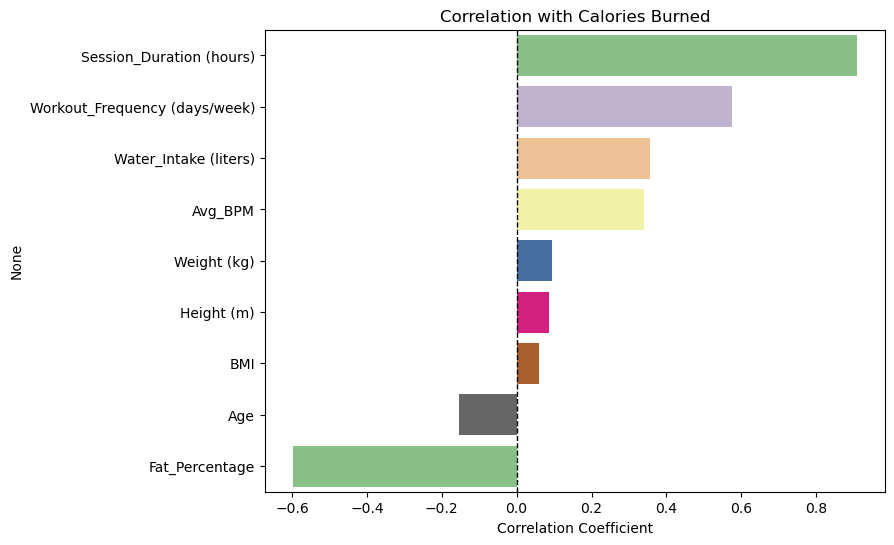

In [107]:
# Prepare data for visualization
plot_data = calories_corr

# Create a horizontal bar plot to visualize correlation magnitudes
plt.figure(figsize=(8, 6))
sns.barplot(x=plot_data.values, y=plot_data.index, palette='Accent')

plt.title('Correlation with Calories Burned')
plt.xlabel('Correlation Coefficient') 
plt.axvline(x=0, color='black', linestyle='--', linewidth=1) 
plt.show() 

**Key Drivers of Energy Expenditure:** The correlation analysis reveals that Session Duration and Workout Frequency are the primary drivers of total caloric burn. This suggests that "Total Volume", the cumulative time spent active, is the most significant predictor in this dataset.

**Inverse Relationships:** Conversely, Body Fat Percentage shows the strongest negative correlation with calories burned. This is likely because individuals with higher lean muscle mass tend to burn more calories during physical activity.

**Counter-Intuitive Findings:** Interestingly, the data reveals a surprisingly weak correlation between Average BPM and total calories. Generally, one would expect that a higher average heart rate (BPM) would burn more calories, these results suggest that for this specific sample, duration and activity type have a much stronger influence on calorie burn than intensity. This highlights the importance of session length over heart rate peaks for maximizing total caloric expenditure.

## 5.0 Hypothesis Testing: Calories Burned by Workout Type

Based on the exploratory data analysis, only small differences were observed in the average calories burned across different workout types. To formally test whether these differences are statistically significant, a one-way ANOVA was conducted.

Because this analysis involves comparing more than two workout groups, I decided that an ANOVA is more appropriate than multiple pairwise t-tests and it helps control for Type I error.

### Hypotheses:

 **Null Hypothesis (H₀):**  
  The mean calories burned is the same across all workout types (Cardio, Strength, HIIT, Yoga).

**Alternative Hypothesis (H₁):**  
  At least one workout type has a different mean calories burned.

In [108]:
# Extract calories burned values for each workout type to prepare for ANOVA analysis
cardio = exercise_df[exercise_df["Workout_Type"] == "Cardio"]["Calories_Burned"]
strength = exercise_df[exercise_df["Workout_Type"] == "Strength"]["Calories_Burned"]
hiit = exercise_df[exercise_df["Workout_Type"] == "HIIT"]["Calories_Burned"]
yoga = exercise_df[exercise_df["Workout_Type"] == "Yoga"]["Calories_Burned"]

# Perform one-way ANOVA test to determine if differences in mean calories burned between groups are statistically significant
f_stat, p_value = f_oneway(cardio, strength, hiit, yoga)

print("F-statistic:", f_stat)
print("p-value:", p_value)

F-statistic: 0.9490432300464533
p-value: 0.4162395222885328


### Results

The one-way ANOVA produced the following results:

- **F-statistic:** 0.949  
- **p-value:** 0.416  

Using a significance level of α = 0.05, the p-value is greater than the threshold for statistical significance.


### Interpretation

Since the p-value (0.416) is greater than the significance level of 0.05, the null hypothesis cannot be rejected. This indicates that there is no statistically significant difference in mean calories burned across the four workout types (Cardio, Strength, HIIT, and Yoga) in this dataset.

Although exploratory analysis suggested slight variation in average calories burned between workout types, the ANOVA results show that these differences are not strong enough to rule out random variation.

### Context and Limitations

The lack of statistical significance may be influenced by factors such as sample size, variability in workout duration, and individual differences (e.g., age, weight, and fitness level). 

The one-way ANOVA tested whether workout type *alone* explains differences in calories burned. However, calorie expenditure is a multivariable outcome, assessing workout type alone fails to account for the variance introduced by other factors.

Because the ANOVA results were not statistically significant, I shifted from a univariate approach to **Multiple Linear Regression**. This allows for a better representation of how these additional variables help explain variation in calories burned. This approach provides a much more accurate analysis of what actually drives calorie burn.

## 6.0 Regression Model

#### Objective

The goal of this analysis is to identify which variables are most strongly associated with calories burned during a workout session, while controlling for other relevant factors.

The regression model includes:
- Session duration  
- Average heart rate  
- Age
- Workout Frequency
- Fat Percentage  
- Workout type (encoded as categorical variables)

#### Data Cleaning and Type Conversion

In [109]:
# Import statsmodels library for statistical modeling and linear regression analysis
import statsmodels.api as sm

In [110]:
# Convert Workout_Type categorical column into binary (one-hot) encoded columns
# drop_first=True removes one category to serve as reference group and avoid multicollinearity
df_encoded = pd.get_dummies(exercise_df, columns=["Workout_Type"], drop_first=True)

# Display all column names to verify the encoding was applied
df_encoded.columns

Index(['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Avg_BPM',
       'Session_Duration (hours)', 'Calories_Burned', 'Cal_Burned_Per_Min',
       'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI',
       'Workout_Type_HIIT', 'Workout_Type_Strength', 'Workout_Type_Yoga'],
      dtype='object')

In [111]:
# Display data types of all columns in the encoded dataframe to verify proper formatting
df_encoded.dtypes

Age                                 int64
Gender                           category
Weight (kg)                       float64
Height (m)                        float64
Avg_BPM                             int64
Session_Duration (hours)          float64
Calories_Burned                   float64
Cal_Burned_Per_Min                float64
Fat_Percentage                    float64
Water_Intake (liters)             float64
Workout_Frequency (days/week)       int64
Experience_Level                   object
BMI                               float64
Workout_Type_HIIT                    bool
Workout_Type_Strength                bool
Workout_Type_Yoga                    bool
dtype: object

Workout type was encoded using dummy variables, with one category dropped to serve as the reference group. The omitted category (Workout_Type_Cardio) represents the baseline against which other workout types are compared.


In [112]:
# Define target variable
y = df_encoded["Calories_Burned"]

# Define the independent variables
cols_to_convert = [
    "Session_Duration (hours)",  
    "Avg_BPM",  
    "Age",
    "Fat_Percentage",
    "Workout_Frequency (days/week)",  
] + [col for col in df_encoded.columns if "Workout_Type_" in col]

# Create feature matrix containing only the selected columns
X = df_encoded[cols_to_convert]

**Feature Selection and Redundancy**

To keep the model simple and interpretable, I removed a few variables that didn’t add unique value:

**Multicollinearity:** Metrics such as Weight, Height, and BMI are mathematically linked. Including all three would introduce multicollinearity, which makes coefficient interpretation less meaningful.

**Prioritizing Key Drivers:** While Fat_Percentage and Weight are related, Fat_Percentage demonstrated a much stronger regression coefficient ($β = -18.8$). I chose to retain it as the main measure of body composition to maintain model clarity and avoid redundant data.

**Confounding Factors:** Although Water_Intake showed a positive coefficient in the regression, it was identified as a confounding variable. The increase in calories burned appeared to be driven by workout duration as longer workouts naturally lead to more water consumption. I excluded it to prevent misleading conclusions. 

In [113]:
# Display data types for all feature variables to ensure proper formatting
X.dtypes

Session_Duration (hours)         float64
Avg_BPM                            int64
Age                                int64
Fat_Percentage                   float64
Workout_Frequency (days/week)      int64
Workout_Type_HIIT                   bool
Workout_Type_Strength               bool
Workout_Type_Yoga                   bool
dtype: object

In [114]:
# Convert all feature values to numeric type for regression model compatibility
X = X.astype(int)

X = X.apply(pd.to_numeric, errors="coerce")  # Ensure all values are numeric, convert errors to NaN
y = pd.to_numeric(y, errors="coerce")  # Convert target variable to numeric, handle conversion errors

In [115]:
# Remove rows with missing values from both X and y to ensure clean dataset for modeling
valid_idx = X.dropna().index.intersection(y.dropna().index)

# Keep only rows with valid indices
X = X.loc[valid_idx]
y = y.loc[valid_idx]

In [116]:
# Add constant term for intercept
X = sm.add_constant(X)

In [117]:
# Fit an Ordinary Least Squares (OLS) linear regression model
model = sm.OLS(y, X).fit()

# print model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     441.2
Date:                Tue, 20 Jan 2026   Prob (F-statistic):          5.59e-316
Time:                        18:01:49   Log-Likelihood:                -6088.0
No. Observations:                 973   AIC:                         1.219e+04
Df Residuals:                     964   BIC:                         1.224e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           253.1771     54.143      4.676      0.000     146.925     359.429
Session_Duration (hours)        341.5243     11.656     29.299      0.000     318.649     364.399
Avg_BPM                           5.9778      0.285     21.001      0.000       5.419       6.536
Age                              -3.8301      0.335    -11.447      0.000      -4.487      -3.174
Fat_Percentage                  -18.8163      0.776    -24.237      0.000     -20.340     -17.293
Workout_Frequency (days/week)    35.9052      5.858      6.130      0.000      24.410      47.400
Workout_Type_HIIT                12.4838     11.684      1.068      0.286     -10.444      35.412
Workout_Type_Strength            10.9974     11.227      0.980      0.328     -11.034      33.029
Workout_Type_Yoga                 4.2403     11.450      0.370      0.711     -18.229      26.710
==============================================================================
Omnibus:                       11.352   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                7.350
Skew:                          -0.020   Prob(JB):                       0.0254
Kurtosis:                       2.576   Cond. No.                     2.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**The table above provides a useful overall summary; however, it is difficult to read in its current form. The following section presents a cleaner data frame and a visualization to improve clarity and interpretability**

### 6.1 Model Interpretation
The visualization below highlights how each feature influences calorie expenditure. The table that follows breaks down the corresponding regression coefficients and their statistical significance, providing a clearer view of each variable’s contribution. 

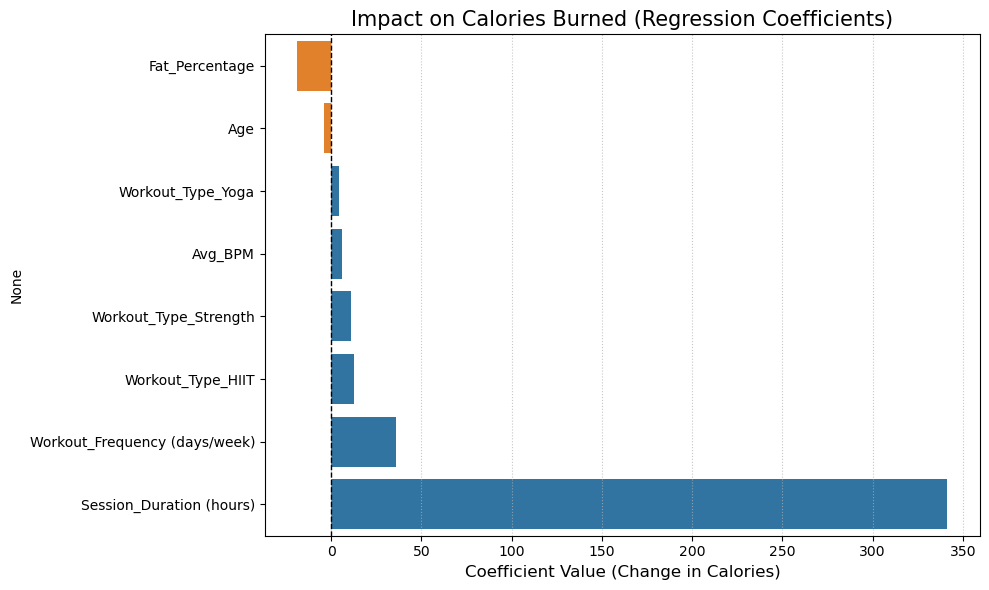

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort values for a better visual flow
plot_data = model.params.drop('const').sort_values()

plt.figure(figsize=(10, 6))
colors = ['#ff7f0e' if x < 0 else '#1f77b4' for x in plot_data] # Orange for negative, Blue for positive

sns.barplot(x=plot_data.values, y=plot_data.index, palette=colors)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('Impact on Calories Burned (Regression Coefficients)', fontsize=15)
plt.xlabel('Coefficient Value (Change in Calories)', fontsize=12)
plt.grid(axis='x', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show() 

In [119]:
# 1. Extract results into a DataFrame
results_df = pd.DataFrame({
    'Coefficient': model.params,
    'P-Value': model.pvalues,
    'Std. Error': model.bse
})

# 2. Add a background gradient and format numbers
styled_results = results_df.style.background_gradient(cmap='bone', subset=['Coefficient']) \
                           .format("{:.3f}") \
                           .set_caption("OLS Regression Results: Feature Impact")

styled_results

,Coefficient,P-Value,Std. Error
const,253.177,0.000,54.143
Session_Duration (hours),341.524,0.000,11.656
Avg_BPM,5.978,0.000,0.285
Age,-3.830,0.000,0.335
Fat_Percentage,-18.816,0.000,0.776
Workout_Frequency (days/week),35.905,0.000,5.858
Workout_Type_HIIT,12.484,0.286,11.684
Workout_Type_Strength,10.997,0.328,11.227
Workout_Type_Yoga,4.240,0.711,11.450


All features are statistically significant at the 0.05 level except for workout type. While these categories appear in the visualization, their effects are not statistically significant.

### Feature Selection and Model Refinement

Gender was initially included as a control variable to account for potential physiological differences in calorie expenditure between males and females. While the gender coefficient was statistically significant, its effect was relatively small and became redundant once body fat percentage was included in the model.

Because body fat percentage provides a more precise measurement of the composition differences that Gender usually represents, retaining both variables would introduce unnecessary redundancy. As a result, gender was removed from the final model to focus on more meaningful predictors of energy expenditure.

### Regression Results Summary

The multiple linear regression model explains approximately 78.5% of the variance in calories burned (R² = 0.785), indicating a strong relationship between the selected predictors and calorie expenditure. The overall model is statistically significant (p < 0.001).

- **Primary Drivers:** Unsurprisingly, Session Duration is the most influential factor; for every additional hour of exercise, calorie burn increases by approximately 342 calories, assuming all other factors remain equal. Interestingly, Workout Frequency also plays a role, with each additional day per week burning about 36 more calories. 

- **Biological Constraints:** Both Age and Body Fat Percentage show a negative relationship with calorie burn. In fact, body fat was one of the model’s strongest predictors; for every 1% increase in fat percentage, the total burn drops by roughly 19 calories.

This result is consistent with exercise physiology, as individuals with lower body fat possess more lean muscle mass, which leads to higher metabolic efficiency and energy expenditure during a workout. 

### Role of Workout Type

Workout type was included in the model using Cardio as the reference category. After controlling for session duration, heart rate, weight, and age, none of the workout types (HIIT, Strength, or Yoga) showed a statistically significant difference in calories burned compared to Cardio.

This suggests that calorie burn is more effected by how long and how frequently individuals exercise rather than the specific workout category.

This helps explain why the earlier ANOVA did not detect statistically significant differences when comparing workout types alone.

### Connection to ANOVA Results

The ANOVA analysis showed no statistically significant difference in mean calories burned across workout types. The regression analysis supports this and provides additional context by demonstrating that once key continuous variables such as duration and intensity are accounted for, workout type alone does not appear to be a strong independent predictor of calories burned.

Together, these analyses suggest that workout type alone is not a sufficient predictor of calories burned without considering workout intensity, frequency, and duration.

## Final Insights

This project analyzed the key factors influencing calories burned during workout sessions using exploratory data analysis and multiple linear regression.

The final regression model explains nearly **79% of the variance** in the data, indicating strong explanatory power for a real-world fitness dataset. The most influential predictors were session duration, workout frequency, body fat percentage, and average heart rate.

Session duration and workout frequency were the strongest positive predictors, suggesting that both workout length and frequency play a critical role in energy expenditure. The data confirms that longer sessions and more consistent sessions are associated with substantially higher calorie burn.

Body fat percentage showed a strong negative relationship with calories burned. Holding other variables constant, higher fat percentage was associated with lower calorie expenditure per session. This aligns with physiological principles, where individuals with leaner body compositions tend to have higher metabolic efficiency during physical activities

Age also demonstrated a statistically significant negative relationship with calories burned, reflecting a gradual metabolic decline with age when other variables are controlled.

Categorical variables such as workout type and gender were tested but ignored in the final model. Once physiological variables (heart rate, duration, fat percentage) were included, these categorical features provided minimal additional explanatory value and became statistically redundant.

Overall, the results suggest that **measurable physiological and intensity-based variables are far more informative than demographic labels or workout categories** when predicting calorie expenditure. This emphasizes the importance of focusing on workout intensity and individual fitness characteristics rather relying on broad classifications.

### 6. References

Data Set Source: https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset 